# Analysis of CMIP6-Decadal Climate Prediction Project (DCPP) output with climpred

Part of talk delivered at NOAA's 45th Climate Diagnostics & Prediction Workshop:
https://talks.andersonbanihirwe.dev/climpred-cdpw-2020.html


## Set up environment


In [1]:
import intake
import proplot as plt
import numpy as np
import xarray as xr
import climpred

## Create and Connect to Dask Distributed Cluster


In [2]:
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
options = gateway.cluster_options()
options.worker_cores = 4
cluster = gateway.new_cluster(cluster_options=options)
cluster.adapt(minimum=2, maximum=100)
# Connect to cluster
client = Client(cluster)
# Display cluster dashboard URL
cluster

## Load `intake-esm` catalog for CMIP6 data residing in Google Cloud Storage

intake-esm: https://intake-esm.readthedocs.io


In [3]:
col = intake.open_esm_datastore(
    "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
)
col

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,unique
activity_id,15
institution_id,34
source_id,79
experiment_id,107
member_id,214
table_id,30
variable_id,393
grid_label,10
zstore,312559
dcpp_init_year,60


In [4]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN,20200310
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190718
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190809
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127


## Set up Hindcast Dataset

Boer, G. J., D. M. Smith, C. Cassou, F. Doblas-Reyes, G. Danabasoglu, B.
Kirtman, Y. Kushnir, et al. “The Decadal Climate Prediction Project (DCPP)
Contribution to CMIP6.” Geosci. Model Dev. 9, no. 10 (October 25, 2016):
3751–77. https://doi.org/10/f89qdf.


In [5]:
variable_id = "tas"
table_id = "Amon"
source_id = "CanESM5"
member_ids = ["r10i1p2f1", "r11i1p2f1", "r12i1p2f1", "r13i1p2f1", "r14i1p2f1"]
inits = list(np.arange(1970, 2015))
cat_cmip = col.search(
    experiment_id=["dcppA-hindcast"],
    table_id=table_id,
    variable_id=variable_id,
    source_id=source_id,
    dcpp_init_year=inits,
)
cat_cmip.df["dcpp_init_year"] = cat_cmip.df.dcpp_init_year.astype(int)

In [6]:
def preprocess(ds):
    # make time dim identical
    ds = climpred.shared.set_integer_time_axis(ds, time_dim="time")
    return ds


dsets = cat_cmip.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "use_cftime": True},
    preprocess=preprocess,
)
[key for key in dsets]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['DCPP.CCCma.CanESM5.dcppA-hindcast.Amon.gn']

In [7]:
hind = dsets["DCPP.CCCma.CanESM5.dcppA-hindcast.Amon.gn"]
hind = hind[variable_id].squeeze()
hind

,Array,Chunk
Bytes,3.54 GB,3.93 MB
Shape,"(20, 45, 120, 64, 128)","(1, 1, 120, 64, 128)"
Count,5400 Tasks,900 Chunks
Type,float32,numpy.ndarray


In [8]:
hind = climpred.shared.rename_to_climpred_dims(hind)

# throw away first two leads and create annual means
hind = hind.isel(lead=slice(2, None))

# Arbitrary dates to just get annual means for lead.
hind["lead"] = xr.cftime_range(start="2000", freq="MS", periods=hind.lead.size)

hind_ym = hind.groupby("lead.year").mean().rename({"year": "lead"})
hind_ym["lead"] = np.arange(1, 1 + hind_ym.lead.size)

# climpred looks for this to know lead time resolution.
hind_ym["lead"].attrs["units"] = "years"
hind_ym

,Array,Chunk
Bytes,294.91 MB,32.77 kB
Shape,"(20, 45, 10, 64, 128)","(1, 1, 1, 64, 128)"
Count,51300 Tasks,9000 Chunks
Type,float32,numpy.ndarray


In [9]:
hind_ym = hind_ym.compute()

## Get Assimilation to Verify


In [10]:
cat_cmip_hist = col.search(
    experiment_id=["dcppA-assim"],
    table_id=table_id,
    variable_id=variable_id,
    source_id=source_id,
)
dsets = cat_cmip_hist.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "use_cftime": True},
)
[key for key in dsets]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['DCPP.CCCma.CanESM5.dcppA-assim.Amon.gn']

In [11]:
assim = dsets["DCPP.CCCma.CanESM5.dcppA-assim.Amon.gn"]
assim = assim[variable_id].squeeze()
assim

<xarray.DataArray 'tas' (member_id: 10, time: 708, lat: 64, lon: 128)>
dask.array<concatenate, shape=(10, 708, 64, 128), dtype=float32, chunksize=(1, 600, 64, 128), chunktype=numpy.ndarray>
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time       (time) object 1958-01-16 12:00:00 ... 2016-12-16 12:00:00
  * member_id  (member_id) <U9 'r10i1p2f1' 'r1i1p2f1' ... 'r8i1p2f1' 'r9i1p2f1'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        ST+273.16, DCPP_table_comment: near-surface (usually, 2 m...
    history:        degctok 2019-06-12T23:46:12Z altered by CMOR: Treated sca...
    long_name:      Near-Surface Air Temperature
    original_name:  ST
    standard_name:  air_temperature
    units:          K

In [12]:
assim = assim.rename({"member_id": "member"})
assim = assim.sel(time=slice("1960", "2015"))
assim_ym = assim.groupby("time.year").mean().rename({"year": "time"})

# Not sure if this is the right thing for verification, but just going to compare
# against the ensemble mean for the assimilation run.
assim_ym = assim_ym.mean("member")
assim_ym

<xarray.DataArray 'tas' (time: 56, lat: 64, lon: 128)>
dask.array<mean_agg-aggregate, shape=(56, 64, 128), dtype=float32, chunksize=(1, 64, 128), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time     (time) int64 1960 1961 1962 1963 1964 ... 2011 2012 2013 2014 2015

In [13]:
assim_ym = assim_ym.compute()

## Create `climpred` Objects

climpred: https://climpred.readthedocs.io/


In [15]:
hindcast = climpred.HindcastEnsemble(hind_ym).add_observations(assim_ym)
hindcast

/srv/conda/envs/notebook/lib/python3.7/site-packages/climpred/utils.py:141: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  "Assuming annual resolution due to numeric inits. "


climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (init: 45, lat: 64, lead: 10, lon: 128, member: 20)
Coordinates:
 height float64 2.0
 * lat (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
 * lon (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
 * init (init) object 1970-01-01 00:00:00 ... 2014-01-01 00:00:00
 * member (member) <U9 'r10i1p2f1' 'r11i1p2f1' ... 'r8i1p2f1' 'r9i1p2f1'
 * lead (lead) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
 tas (member, init, lead, lat, lon) float32 230.558 ... 263.46442 Initialized Ensemble Dimensions: init : 45 lat : 64 lead : 10 lon : 128 member : 20 Coordinates: (6) height () float64 2.0 axis : Z long_name : height positive : up standard_name : height units : m array(2.) lat (lat) float64 -87.86 -85.1 -82.31 ... 85.1 87.86 axis : Y bounds : lat_bnds long_name : Latitude standard_name : latitude units : degrees_north array([-87.863799, -85.096527, -82.312913, -79.525607, -76.7369 , -73.947515,
 -71.157752, -68.367756, -65.577607, -62.787352, -59.99702 , -57.206632,
 -54.4162 , -51.625734, -48.835241, -46.044727, -43.254195, -40.463648,
 -37.67309 , -34.882521, -32.091944, -29.30136 , -26.510769, -23.720174,
 -20.929574, -18.138971, -15.348365, -12.557756, -9.767146, -6.976534,
 -4.185921, -1.395307, 1.395307, 4.185921, 6.976534, 9.767146,
 12.557756, 15.348365, 18.138971, 20.929574, 23.720174, 26.510769,
 29.30136 , 32.091944, 34.882521, 37.67309 , 40.463648, 43.254195,
 46.044727, 48.835241, 51.625734, 54.4162 , 57.206632, 59.99702 ,
 62.787352, 65.577607, 68.367756, 71.157752, 73.947515, 76.7369 ,
 79.525607, 82.312913, 85.096527, 87.863799]) lon (lon) float64 0.0 2.812 5.625 ... 354.4 357.2 axis : X bounds : lon_bnds long_name : Longitude standard_name : longitude units : degrees_east array([ 0. , 2.8125, 5.625 , 8.4375, 11.25 , 14.0625, 16.875 ,
 19.6875, 22.5 , 25.3125, 28.125 , 30.9375, 33.75 , 36.5625,
 39.375 , 42.1875, 45. , 47.8125, 50.625 , 53.4375, 56.25 ,
 59.0625, 61.875 , 64.6875, 67.5 , 70.3125, 73.125 , 75.9375,
 78.75 , 81.5625, 84.375 , 87.1875, 90. , 92.8125, 95.625 ,
 98.4375, 101.25 , 104.0625, 106.875 , 109.6875, 112.5 , 115.3125,
 118.125 , 120.9375, 123.75 , 126.5625, 129.375 , 132.1875, 135. ,
 137.8125, 140.625 , 143.4375, 146.25 , 149.0625, 151.875 , 154.6875,
 157.5 , 160.3125, 163.125 , 165.9375, 168.75 , 171.5625, 174.375 ,
 177.1875, 180. , 182.8125, 185.625 , 188.4375, 191.25 , 194.0625,
 196.875 , 199.6875, 202.5 , 205.3125, 208.125 , 210.9375, 213.75 ,
 216.5625, 219.375 , 222.1875, 225. , 227.8125, 230.625 , 233.4375,
 236.25 , 239.0625, 241.875 , 244.6875, 247.5 , 250.3125, 253.125 ,
 255.9375, 258.75 , 261.5625, 264.375 , 267.1875, 270. , 272.8125,
 275.625 , 278.4375, 281.25 , 284.0625, 286.875 , 289.6875, 292.5 ,
 295.3125, 298.125 , 300.9375, 303.75 , 306.5625, 309.375 , 312.1875,
 315. , 317.8125, 320.625 , 323.4375, 326.25 , 329.0625, 331.875 ,
 334.6875, 337.5 , 340.3125, 343.125 , 345.9375, 348.75 , 351.5625,
 354.375 , 357.1875]) init (init) object 1970-01-01 00:00:00 ... 2014-01-... array([cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1976, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1977, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1978, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1980, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1982, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1983, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1984, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1985, 1, 1, 0, 0, 0,

<Observations>
Dimensions: (lat: 64, lon: 128, time: 56)
Coordinates:
 height float64 2.0
 * lat (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
 * lon (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
 * time (time) object 1960-01-01 00:00:00 ... 2015-01-01 00:00:00
Data variables:
 tas (time, lat, lon) float32 232.12617 231.82523 ... 257.77576 Observations Dimensions: lat : 64 lon : 128 time : 56 Coordinates: (4) height () float64 2.0 axis : Z long_name : height positive : up standard_name : height units : m array(2.) lat (lat) float64 -87.86 -85.1 -82.31 ... 85.1 87.86 axis : Y bounds : lat_bnds long_name : Latitude standard_name : latitude units : degrees_north array([-87.863799, -85.096527, -82.312913, -79.525607, -76.7369 , -73.947515,
 -71.157752, -68.367756, -65.577607, -62.787352, -59.99702 , -57.206632,
 -54.4162 , -51.625734, -48.835241, -46.044727, -43.254195, -40.463648,
 -37.67309 , -34.882521, -32.091944, -29.30136 , -26.510769, -23.720174,
 -20.929574, -18.138971, -15.348365, -12.557756, -9.767146, -6.976534,
 -4.185921, -1.395307, 1.395307, 4.185921, 6.976534, 9.767146,
 12.557756, 15.348365, 18.138971, 20.929574, 23.720174, 26.510769,
 29.30136 , 32.091944, 34.882521, 37.67309 , 40.463648, 43.254195,
 46.044727, 48.835241, 51.625734, 54.4162 , 57.206632, 59.99702 ,
 62.787352, 65.577607, 68.367756, 71.157752, 73.947515, 76.7369 ,
 79.525607, 82.312913, 85.096527, 87.863799]) lon (lon) float64 0.0 2.812 5.625 ... 354.4 357.2 axis : X bounds : lon_bnds long_name : Longitude standard_name : longitude units : degrees_east array([ 0. , 2.8125, 5.625 , 8.4375, 11.25 , 14.0625, 16.875 ,
 19.6875, 22.5 , 25.3125, 28.125 , 30.9375, 33.75 , 36.5625,
 39.375 , 42.1875, 45. , 47.8125, 50.625 , 53.4375, 56.25 ,
 59.0625, 61.875 , 64.6875, 67.5 , 70.3125, 73.125 , 75.9375,
 78.75 , 81.5625, 84.375 , 87.1875, 90. , 92.8125, 95.625 ,
 98.4375, 101.25 , 104.0625, 106.875 , 109.6875, 112.5 , 115.3125,
 118.125 , 120.9375, 123.75 , 126.5625, 129.375 , 132.1875, 135. ,
 137.8125, 140.625 , 143.4375, 146.25 , 149.0625, 151.875 , 154.6875,
 157.5 , 160.3125, 163.125 , 165.9375, 168.75 , 171.5625, 174.375 ,
 177.1875, 180. , 182.8125, 185.625 , 188.4375, 191.25 , 194.0625,
 196.875 , 199.6875, 202.5 , 205.3125, 208.125 , 210.9375, 213.75 ,
 216.5625, 219.375 , 222.1875, 225. , 227.8125, 230.625 , 233.4375,
 236.25 , 239.0625, 241.875 , 244.6875, 247.5 , 250.3125, 253.125 ,
 255.9375, 258.75 , 261.5625, 264.375 , 267.1875, 270. , 272.8125,
 275.625 , 278.4375, 281.25 , 284.0625, 286.875 , 289.6875, 292.5 ,
 295.3125, 298.125 , 300.9375, 303.75 , 306.5625, 309.375 , 312.1875,
 315. , 317.8125, 320.625 , 323.4375, 326.25 , 329.0625, 331.875 ,
 334.6875, 337.5 , 340.3125, 343.125 , 345.9375, 348.75 , 351.5625,
 354.375 , 357.1875]) time (time) object 1960-01-01 00:00:00 ... 2015-01-... array([cftime.DatetimeProlepticGregorian(1960, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1961, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1962, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1963, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1964, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1965, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1966, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1967, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1968, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1969, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1976, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1977, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1978, 1, 1, 0, 0,

## Verify the initialized ensemble against observations (assimilations).


In [16]:
result = hindcast.verify(
    metric="acc", dim="init", comparison="e2o", alignment="maximize"
)
result

<xarray.Dataset>
Dimensions:  (lat: 64, lead: 10, lon: 128)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
    height   float64 2.0
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    skill    <U11 'initialized'
Data variables:
    tas      (lead, lat, lon) float32 0.26141414 0.26245588 ... 0.6964763

### Look at maps of Anomaly Correlation Coefficient with trend.


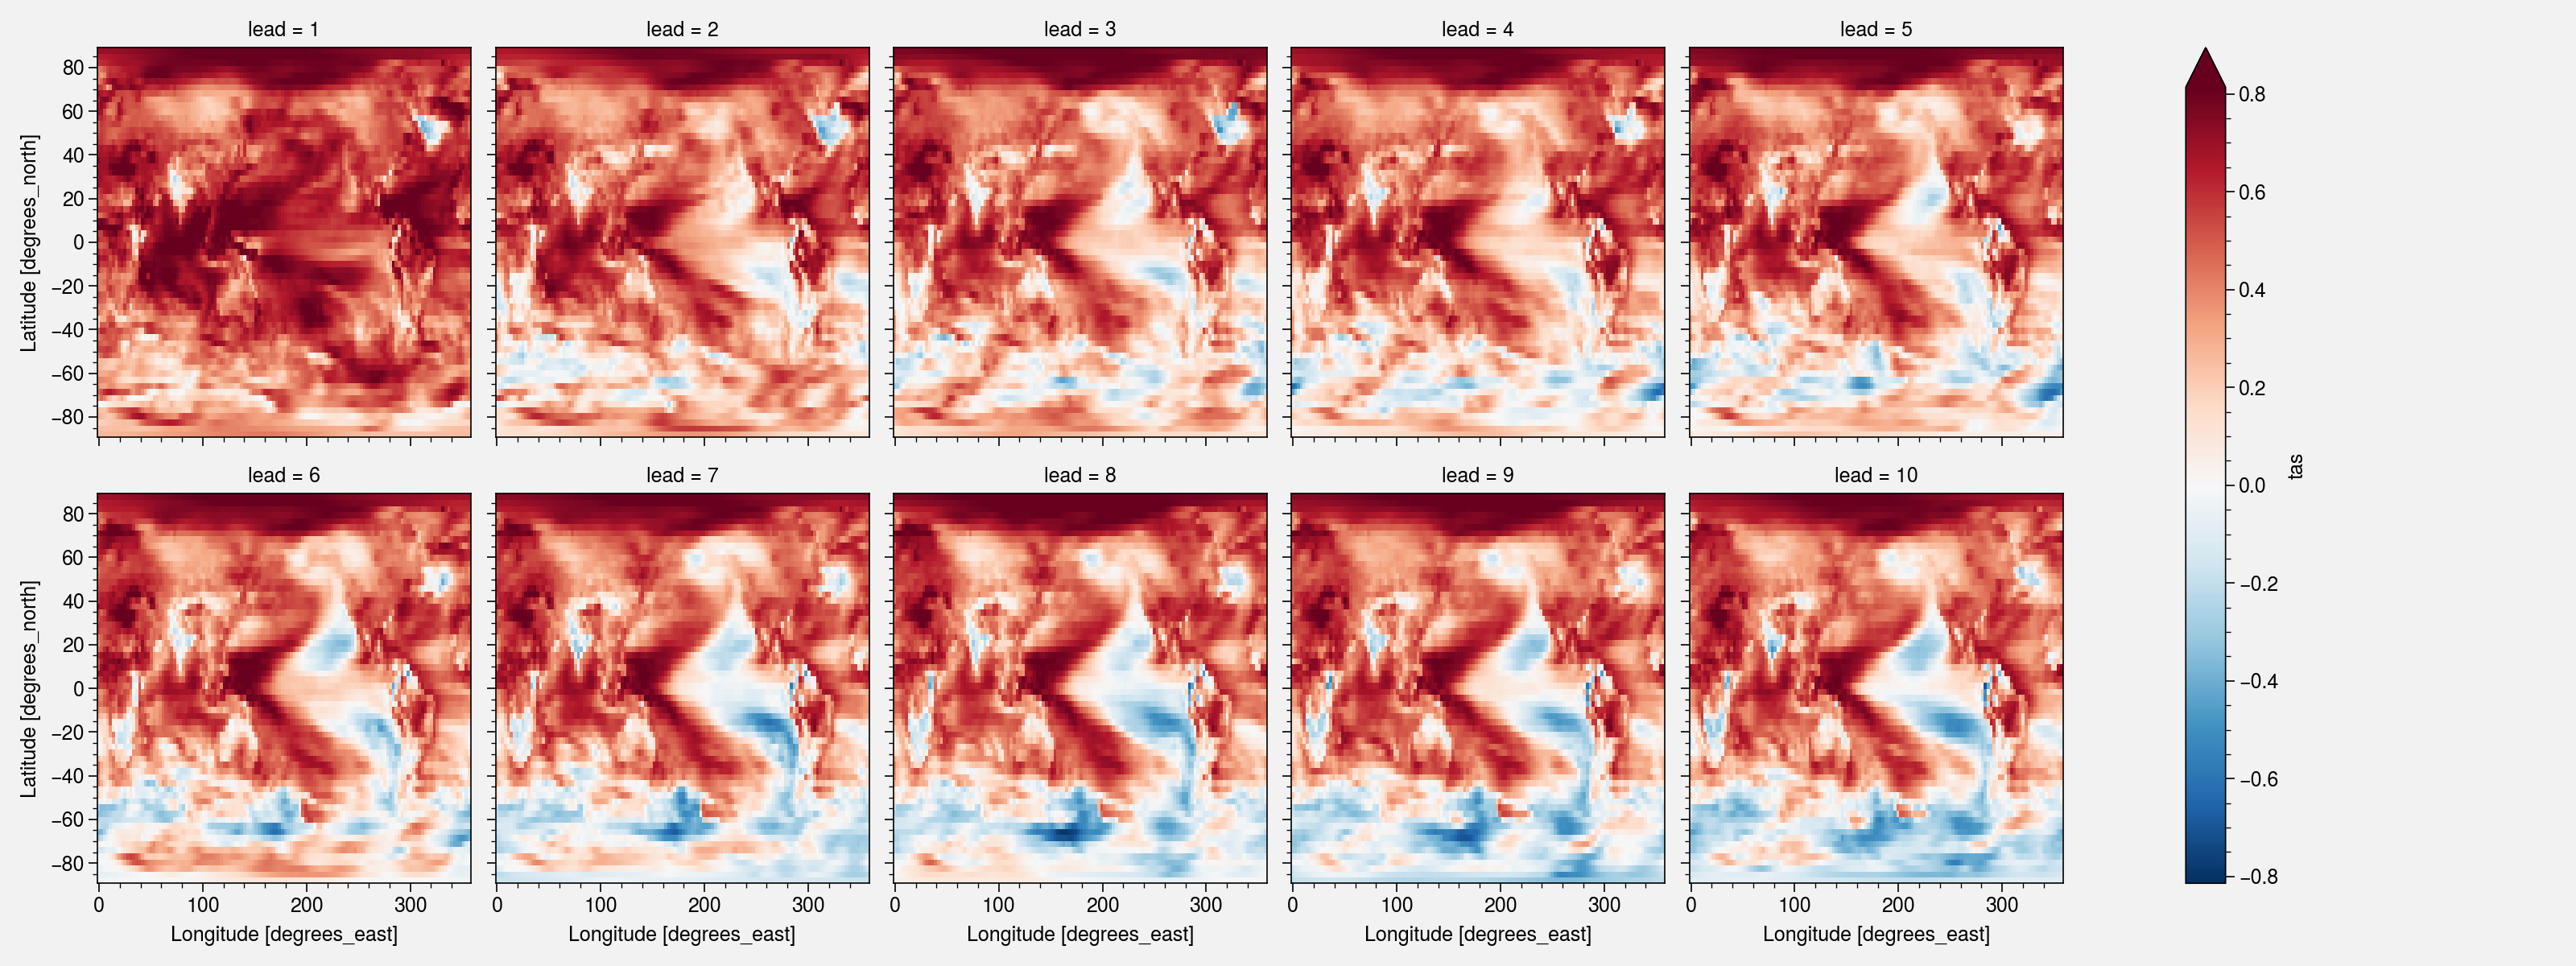

In [17]:
result.tas.plot(col="lead", col_wrap=5, robust=True)

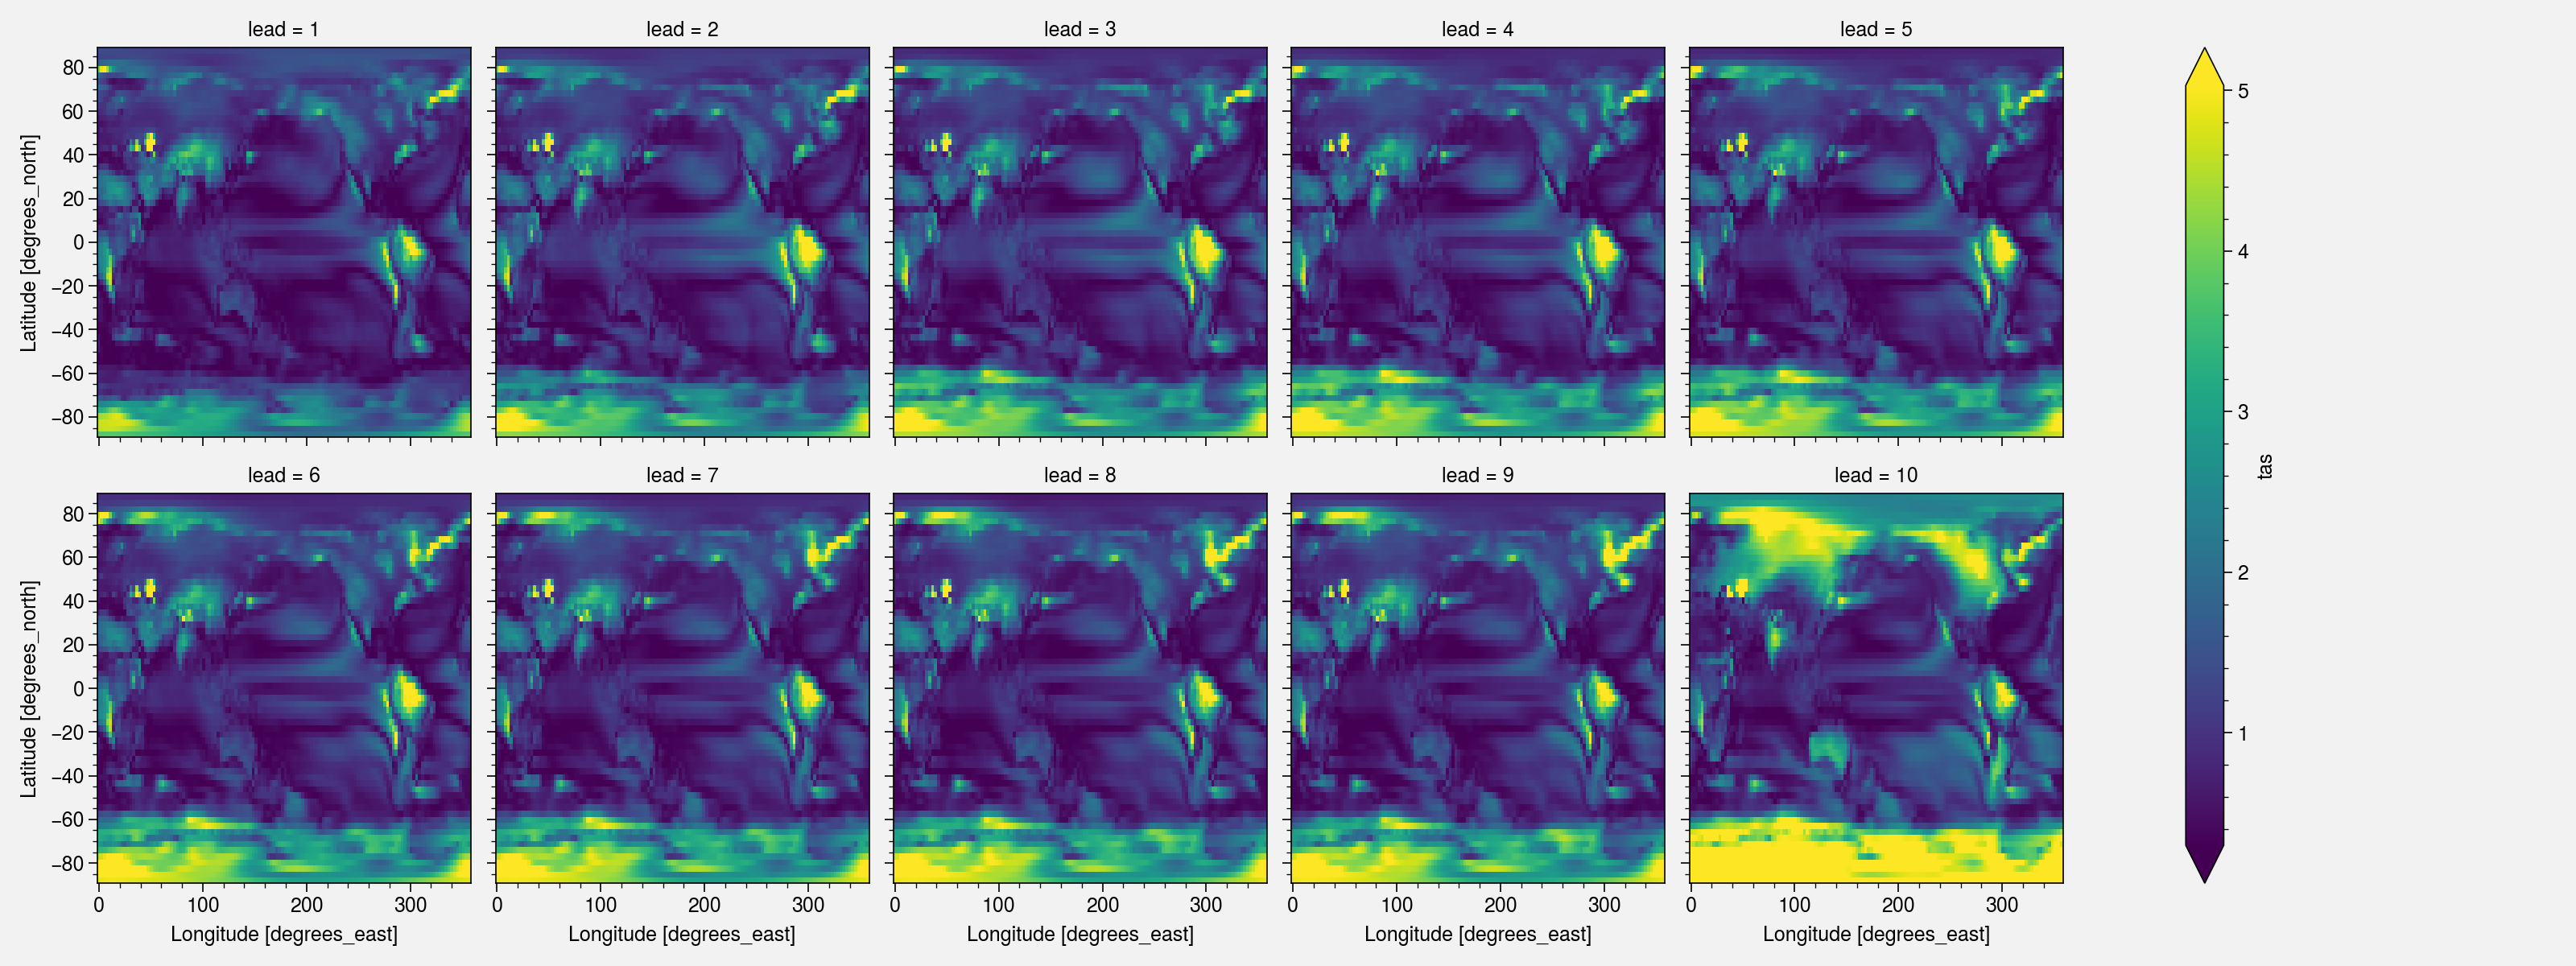

In [18]:
# Can easily change the metric.
result = hindcast.verify(
    metric="rmse", dim="init", comparison="e2o", alignment="maximize"
)
result.tas.plot(col="lead", col_wrap=5, robust=True)

## Detrended Analysis


In [19]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da.coords[dim], p.polyfit_coefficients)
    return da - fit

In [20]:
hind_ym_dt = detrend_dim(hind_ym, dim="init")
assim_ym_dt = detrend_dim(assim_ym, dim="time")

In [21]:
hindcast_dt = climpred.HindcastEnsemble(
    hind_ym_dt.rename("tas")
).add_observations(assim_ym_dt.rename("tas"))
hindcast_dt

/srv/conda/envs/notebook/lib/python3.7/site-packages/climpred/utils.py:141: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  "Assuming annual resolution due to numeric inits. "


climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (init: 45, lat: 64, lead: 10, lon: 128, member: 20)
Coordinates:
 height float64 2.0
 * lat (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
 * lon (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
 * init (init) object 1970-01-01 00:00:00 ... 2014-01-01 00:00:00
 * member (member) <U9 'r10i1p2f1' 'r11i1p2f1' ... 'r8i1p2f1' 'r9i1p2f1'
 * lead (lead) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
 tas (member, init, lead, lat, lon) float64 0.5024 0.5065 ... 0.9485 Initialized Ensemble Dimensions: init : 45 lat : 64 lead : 10 lon : 128 member : 20 Coordinates: (6) height () float64 2.0 axis : Z long_name : height positive : up standard_name : height units : m array(2.) lat (lat) float64 -87.86 -85.1 -82.31 ... 85.1 87.86 axis : Y bounds : lat_bnds long_name : Latitude standard_name : latitude units : degrees_north array([-87.863799, -85.096527, -82.312913, -79.525607, -76.7369 , -73.947515,
 -71.157752, -68.367756, -65.577607, -62.787352, -59.99702 , -57.206632,
 -54.4162 , -51.625734, -48.835241, -46.044727, -43.254195, -40.463648,
 -37.67309 , -34.882521, -32.091944, -29.30136 , -26.510769, -23.720174,
 -20.929574, -18.138971, -15.348365, -12.557756, -9.767146, -6.976534,
 -4.185921, -1.395307, 1.395307, 4.185921, 6.976534, 9.767146,
 12.557756, 15.348365, 18.138971, 20.929574, 23.720174, 26.510769,
 29.30136 , 32.091944, 34.882521, 37.67309 , 40.463648, 43.254195,
 46.044727, 48.835241, 51.625734, 54.4162 , 57.206632, 59.99702 ,
 62.787352, 65.577607, 68.367756, 71.157752, 73.947515, 76.7369 ,
 79.525607, 82.312913, 85.096527, 87.863799]) lon (lon) float64 0.0 2.812 5.625 ... 354.4 357.2 axis : X bounds : lon_bnds long_name : Longitude standard_name : longitude units : degrees_east array([ 0. , 2.8125, 5.625 , 8.4375, 11.25 , 14.0625, 16.875 ,
 19.6875, 22.5 , 25.3125, 28.125 , 30.9375, 33.75 , 36.5625,
 39.375 , 42.1875, 45. , 47.8125, 50.625 , 53.4375, 56.25 ,
 59.0625, 61.875 , 64.6875, 67.5 , 70.3125, 73.125 , 75.9375,
 78.75 , 81.5625, 84.375 , 87.1875, 90. , 92.8125, 95.625 ,
 98.4375, 101.25 , 104.0625, 106.875 , 109.6875, 112.5 , 115.3125,
 118.125 , 120.9375, 123.75 , 126.5625, 129.375 , 132.1875, 135. ,
 137.8125, 140.625 , 143.4375, 146.25 , 149.0625, 151.875 , 154.6875,
 157.5 , 160.3125, 163.125 , 165.9375, 168.75 , 171.5625, 174.375 ,
 177.1875, 180. , 182.8125, 185.625 , 188.4375, 191.25 , 194.0625,
 196.875 , 199.6875, 202.5 , 205.3125, 208.125 , 210.9375, 213.75 ,
 216.5625, 219.375 , 222.1875, 225. , 227.8125, 230.625 , 233.4375,
 236.25 , 239.0625, 241.875 , 244.6875, 247.5 , 250.3125, 253.125 ,
 255.9375, 258.75 , 261.5625, 264.375 , 267.1875, 270. , 272.8125,
 275.625 , 278.4375, 281.25 , 284.0625, 286.875 , 289.6875, 292.5 ,
 295.3125, 298.125 , 300.9375, 303.75 , 306.5625, 309.375 , 312.1875,
 315. , 317.8125, 320.625 , 323.4375, 326.25 , 329.0625, 331.875 ,
 334.6875, 337.5 , 340.3125, 343.125 , 345.9375, 348.75 , 351.5625,
 354.375 , 357.1875]) init (init) object 1970-01-01 00:00:00 ... 2014-01-... array([cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1976, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1977, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1978, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1980, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1982, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1983, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1984, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1985, 1, 1, 0, 0,

<Observations>
Dimensions: (lat: 64, lon: 128, time: 56)
Coordinates:
 height float64 2.0
 * lat (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
 * lon (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
 * time (time) object 1960-01-01 00:00:00 ... 2015-01-01 00:00:00
Data variables:
 tas (time, lat, lon) float64 -1.026 -1.025 -1.028 ... 0.08254 0.07361 Observations Dimensions: lat : 64 lon : 128 time : 56 Coordinates: (4) height () float64 2.0 axis : Z long_name : height positive : up standard_name : height units : m array(2.) lat (lat) float64 -87.86 -85.1 -82.31 ... 85.1 87.86 axis : Y bounds : lat_bnds long_name : Latitude standard_name : latitude units : degrees_north array([-87.863799, -85.096527, -82.312913, -79.525607, -76.7369 , -73.947515,
 -71.157752, -68.367756, -65.577607, -62.787352, -59.99702 , -57.206632,
 -54.4162 , -51.625734, -48.835241, -46.044727, -43.254195, -40.463648,
 -37.67309 , -34.882521, -32.091944, -29.30136 , -26.510769, -23.720174,
 -20.929574, -18.138971, -15.348365, -12.557756, -9.767146, -6.976534,
 -4.185921, -1.395307, 1.395307, 4.185921, 6.976534, 9.767146,
 12.557756, 15.348365, 18.138971, 20.929574, 23.720174, 26.510769,
 29.30136 , 32.091944, 34.882521, 37.67309 , 40.463648, 43.254195,
 46.044727, 48.835241, 51.625734, 54.4162 , 57.206632, 59.99702 ,
 62.787352, 65.577607, 68.367756, 71.157752, 73.947515, 76.7369 ,
 79.525607, 82.312913, 85.096527, 87.863799]) lon (lon) float64 0.0 2.812 5.625 ... 354.4 357.2 axis : X bounds : lon_bnds long_name : Longitude standard_name : longitude units : degrees_east array([ 0. , 2.8125, 5.625 , 8.4375, 11.25 , 14.0625, 16.875 ,
 19.6875, 22.5 , 25.3125, 28.125 , 30.9375, 33.75 , 36.5625,
 39.375 , 42.1875, 45. , 47.8125, 50.625 , 53.4375, 56.25 ,
 59.0625, 61.875 , 64.6875, 67.5 , 70.3125, 73.125 , 75.9375,
 78.75 , 81.5625, 84.375 , 87.1875, 90. , 92.8125, 95.625 ,
 98.4375, 101.25 , 104.0625, 106.875 , 109.6875, 112.5 , 115.3125,
 118.125 , 120.9375, 123.75 , 126.5625, 129.375 , 132.1875, 135. ,
 137.8125, 140.625 , 143.4375, 146.25 , 149.0625, 151.875 , 154.6875,
 157.5 , 160.3125, 163.125 , 165.9375, 168.75 , 171.5625, 174.375 ,
 177.1875, 180. , 182.8125, 185.625 , 188.4375, 191.25 , 194.0625,
 196.875 , 199.6875, 202.5 , 205.3125, 208.125 , 210.9375, 213.75 ,
 216.5625, 219.375 , 222.1875, 225. , 227.8125, 230.625 , 233.4375,
 236.25 , 239.0625, 241.875 , 244.6875, 247.5 , 250.3125, 253.125 ,
 255.9375, 258.75 , 261.5625, 264.375 , 267.1875, 270. , 272.8125,
 275.625 , 278.4375, 281.25 , 284.0625, 286.875 , 289.6875, 292.5 ,
 295.3125, 298.125 , 300.9375, 303.75 , 306.5625, 309.375 , 312.1875,
 315. , 317.8125, 320.625 , 323.4375, 326.25 , 329.0625, 331.875 ,
 334.6875, 337.5 , 340.3125, 343.125 , 345.9375, 348.75 , 351.5625,
 354.375 , 357.1875]) time (time) object 1960-01-01 00:00:00 ... 2015-01-... array([cftime.DatetimeProlepticGregorian(1960, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1961, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1962, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1963, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1964, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1965, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1966, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1967, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1968, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1969, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1976, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1977, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1978, 1, 1

### Comparison of initialized forecast to persistence.


In [22]:
result = hindcast_dt.verify(
    metric="mae",
    comparison="e2o",
    dim="init",
    alignment="maximize",
    reference="persistence",
)

In [23]:
result

<xarray.Dataset>
Dimensions:  (lat: 64, lead: 10, lon: 128, skill: 2)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
    height   float64 2.0
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * skill    (skill) <U11 'initialized' 'persistence'
Data variables:
    tas      (skill, lead, lat, lon) float64 0.58 0.5828 0.5855 ... 1.1 1.106

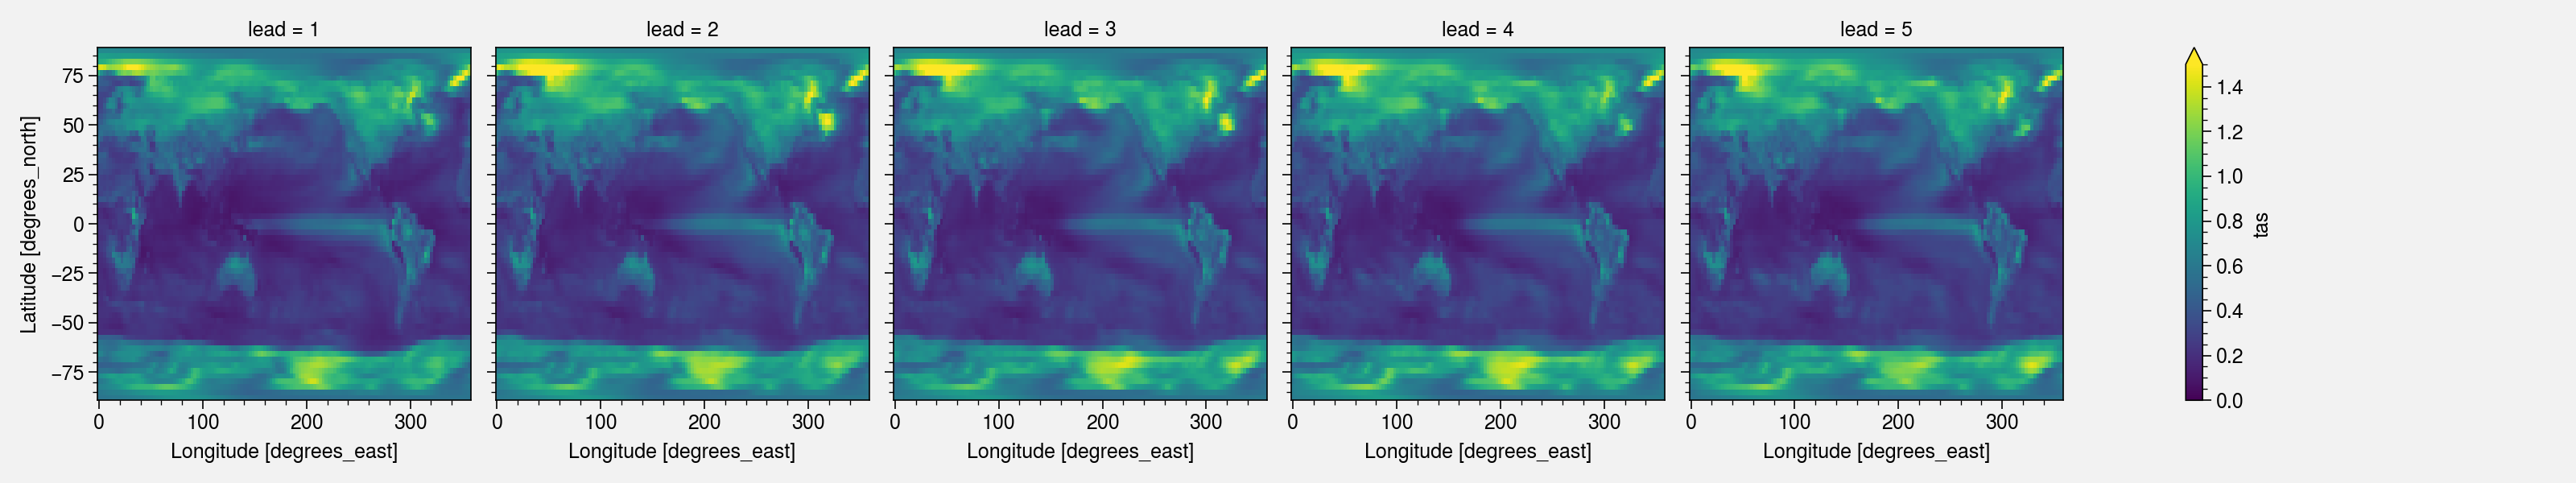

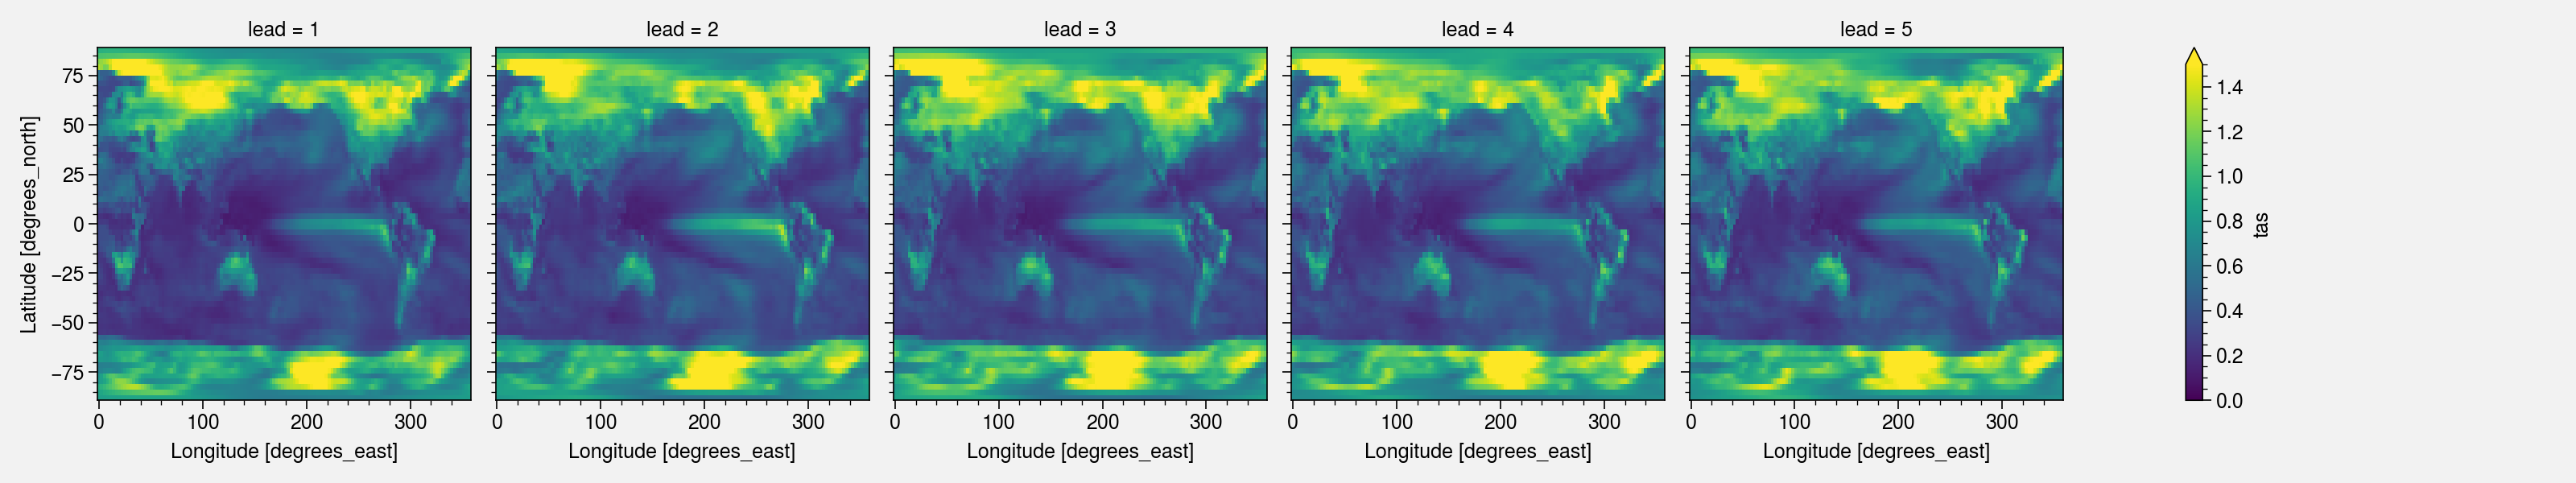

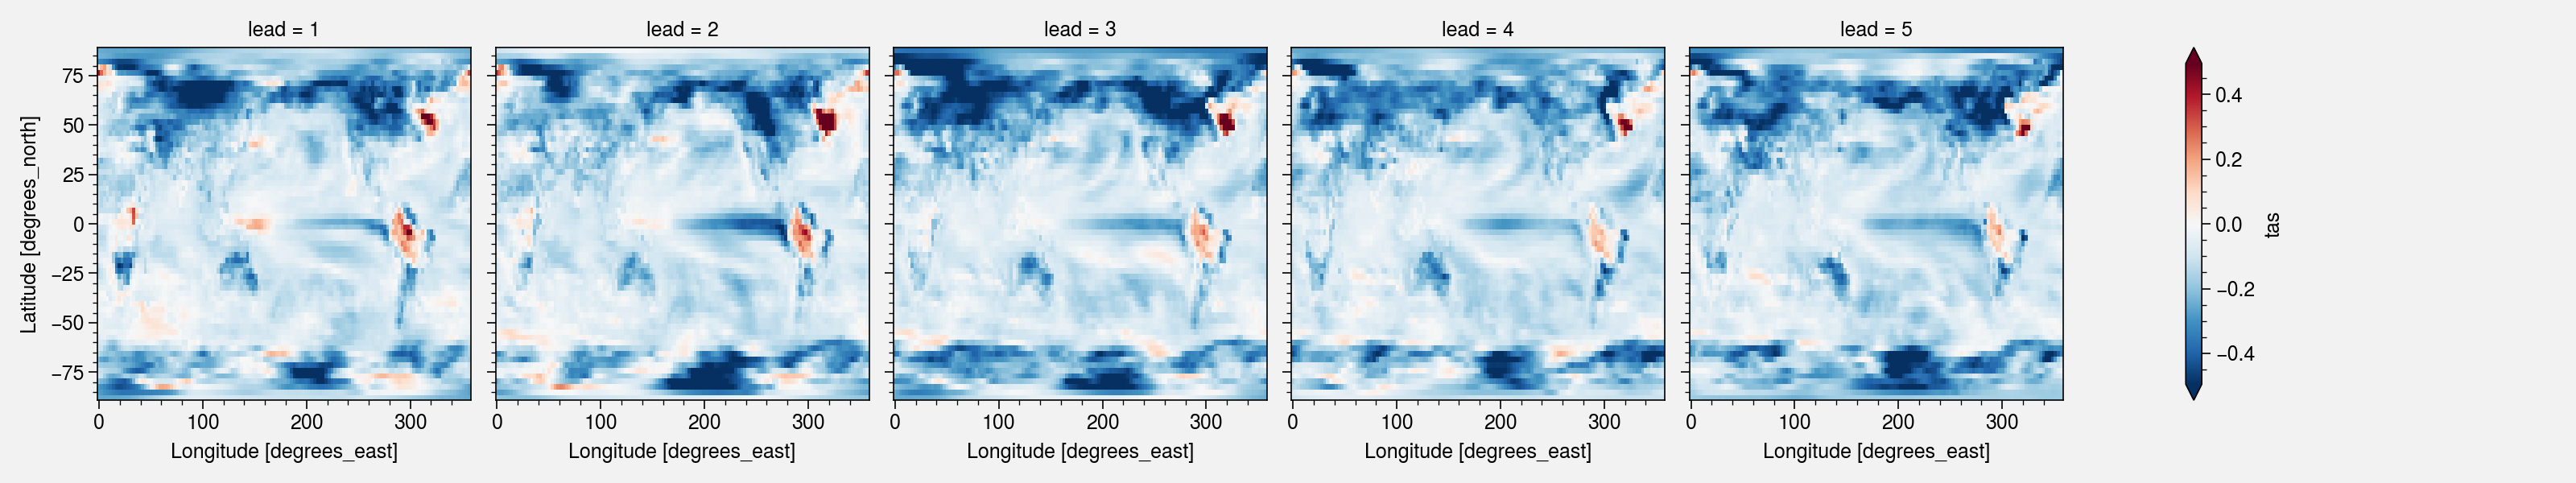

In [24]:
result.sel(skill="initialized").isel(lead=slice(0, 5)).tas.plot(
    col="lead", vmin=0, vmax=1.5, robust=True
)
result.sel(skill="persistence").isel(lead=slice(0, 5)).tas.plot(
    col="lead", vmin=0, vmax=1.5, robust=True
)

diff = result.sel(skill="initialized") - result.sel(skill="persistence")
diff.isel(lead=slice(0, 5)).tas.plot(col="lead", robust=True)